# From Vanilla to Variational AutoEncoders (VAE) for visualizing and generating genotypes

**Marcin Kierczak** 22-03-2023

### Synopsis

Here, we will look at stage 3 HapMap genotyping data. In short, these data are genotypes of people coming from different populations across the world. I have randomly selected 5000 autosomal markers that are included in the dataset. 

First, we will use autoencoder to visualize our data in a fashion similar to PCA/MDS. Why? 1) It's fun, 2) contrary to classical PCA, autoencoders can to some extent deal with noisy/missing data (think e.g. aDNA), 3) when we start looking at many markers/loci, like sequencing data, linkage disequilibrium will introduce correlation between markers that will make kinship matrix determinants to be 0 --> PCA will fail.

Next, we will modify our vanilla autoencoder to become a variational autoencoder and we will generate an artificial population of Neverlanders. We will see where will they end up on our embedding space.

### Disclaimer

This lab is very new and highly exploratory. There are some questions or code gaps to fill in for you. But I also highly encourage you to wrap your mind around how a VAE works and how to implement it and to experiment with the architecture of the model. Please, feel free to play around with the code and enjoy the results!

### Initial steps

All initial steps are similar to what you already know from the other lab. 

* load necessary Python modules,
* load genotypes and phenotypes -- here you will have to adjust path,
* build dictionary of populations, I also add a test population of Neverlanders that we will create later,
* scale the data,
* split your data into training and test set, put test set asides


In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras import layers
from keras import backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from keras import backend
from sklearn.decomposition import PCA
from itertools import product

2023-03-23 11:06:50.868275: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load the data

Below, we will load genotypes along with, phenotypes. From the phenotype file, we mostly need the population annotation.

In [2]:
geno = pd.read_csv("~/Dropbox/Public/teaching_materials/datasets/autosomal_5k_matrix.csv", header=0, index_col=0)
pheno = pd.read_csv("~/Dropbox/Public/teaching_materials/datasets/autosomal_5k_phenos.csv", header=0, index_col=0)

print(geno.iloc[0:5, 0:5])
print(pheno.iloc[0:5, 0:7])

         rs416967  rs17013842  rs13052452  rs11049986  rs10994341
NA19919         2           1           0           1           1
NA19916         1           0           0           1           1
NA19835         0           0           1           1           0
NA20282         1           1           0           1           0
NA19703         0           0           0           0           1
              id  sex   FID      dad      mom  pheno population
NA19919  NA19919    1  2427  NA19908  NA19909      0        ASW
NA19916  NA19916    1  2431        0        0      0        ASW
NA19835  NA19835    0  2424        0        0      0        ASW
NA20282  NA20282    0  2469        0        0      0        ASW
NA19703  NA19703    1  2368        0        0      0        ASW


Now, abbreviations like "ASW" are not super informative. Thus, we will create a dictionary that contains more meaningful description of each population.

In [3]:
pop_dict = {'ASW':'African ancestry in SW USA',
            'CEU':'Utah residents with N and W European ancestry',
            'CHB':'Han Chinese in Beijing China',
            'CHD':'Chinese in Metropolitan Denver Colorado',
            'GIH':'Gujarati Indians in Houston Texas',
            'JPT':'Japanese in Tokyo Japan',
            'LWK':'Luhya in Webuye Kenya',
            'MEX':'Mexican ancestry in Los Angeles California',
            'MKK':'Maasai in Kinyawa Kenya',
            'TSI':'Toscans in Italy',
            'YRI':'Yoruba in Ibadan Nigeria',
            'TST':'Test population in Neverland'}
pheno2 = pheno.replace({"population": pop_dict})
pheno2.iloc[0:2, :]

,id,sex,FID,dad,mom,pheno,population
NA19919,NA19919,1,2427,NA19908,NA19909,0,African ancestry in SW USA
NA19916,NA19916,1,2431,0,0,0,African ancestry in SW USA


Below, we perform some scaling so that the input data is bound between 0 and 1. It may not be the best coding as 0 will 'hitchhike' on biases in each layer, but we will not complicate things further here. One-hot encoding or 4-channel representation (probability of A, T, C and G) would be more appropriate. 

### Task 1 
Scale the data so that they are bound between [0, 1].

### Task 2 (optional)
Try different input encoding, e.g. one-hot encoding.


In [4]:
# Scaling 
# We need to scale our counts data so that it is bound between 0 and 1. 
# Now, the AA homozygotes will be coded as 0, heterozygotes as 0.5 and aa homozygotes as 1. 

geno_data = geno / 2
print(geno_data.iloc[0:5, 0:10])

         rs416967  rs17013842  rs13052452  rs11049986  rs10994341  rs1504289  \
NA19919       1.0         0.5         0.0         0.5         0.5        0.0   
NA19916       0.5         0.0         0.0         0.5         0.5        0.0   
NA19835       0.0         0.0         0.5         0.5         0.0        0.5   
NA20282       0.5         0.5         0.0         0.5         0.0        0.0   
NA19703       0.0         0.0         0.0         0.0         0.5        0.5   

         rs882529  rs3885937  rs537330  rs9372090  
NA19919       0.0        0.5       0.5        0.5  
NA19916       0.5        0.5       1.0        0.5  
NA19835       0.0        1.0       1.0        0.5  
NA20282       0.0        0.0       0.5        0.5  
NA19703       0.0        0.0       0.0        1.0  


### Split the data

Now, we split our data into training (which we will further split into proper training set and the validation set) and test set. Test set will be kept away from the entire training process and will be used only to evaluate the final model. Initially, we do not keep any test data. This is to focus on autoencoders per se, not on the model and is only a toy example.

In [5]:
# Randomly split into the training and the test set
data = geno_data
train = data.sample(frac = 1.0, random_state = 42) 
test = data.drop(train.index)
train_pheno = pheno2[pheno2.index.isin(train.index)]
test_pheno = pheno2.drop(train.index)
train.reset_index()
test.reset_index()
train_pheno.reset_index()
test_pheno.reset_index()

# Print some info about the resulting split
print("Number of individuals:", data.shape[0])
print("\t - training set:", train.shape)
print("\t - test set:", test.shape)

Number of individuals: 1184
	 - training set: (1184, 5000)
	 - test set: (0, 5000)


## Our Autoencoder/VAE model

To save our time and work, we will introduce a simple boolean parameter *vanilla*. When **True**, a vanilla autoencoder will be built, but when we set it to **False**, a variational autoencoder model will be built.

### Custom sampling layer

As you, hopefully, remember from the lecture, VAEs need a so-called 'sampling layer' that performs sampling operation from two outputs from the previous layer: z_means and z_log_sigma. Here, we need to implement this layer ourselves as it is not a part of Keras (at least it has not been at the time when I started writing the code).

In [6]:
train_tensor = train.to_numpy()
test_tensor = test.to_numpy()
original_dim = train_tensor.shape[1]
latent_dim = 2
print(type(train_tensor))

vanilla = False

# Custom sampling layer
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean = 0, stddev=.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

<class 'numpy.ndarray'>


### Encoder and Decoder

Next, we will build an encoder remembering that in VAE there are two extra layers: one that will learn means, the other one that will learn variances (std. devs) of out distributions from which the custom sampling layer will sample.

There is nothing special to the decoder part -- it is symmetrical to the decoder about the bottleneck layer.

### Task 3

Implement missing encoder and missing decoder layers. 
For the encoder, start with 3 dense layers with, say, 200, 25 and 5 neurons. Add batch normalization after each dense layer. 

### Task 4

Implement the decoder part by filling in the gaps in the code.

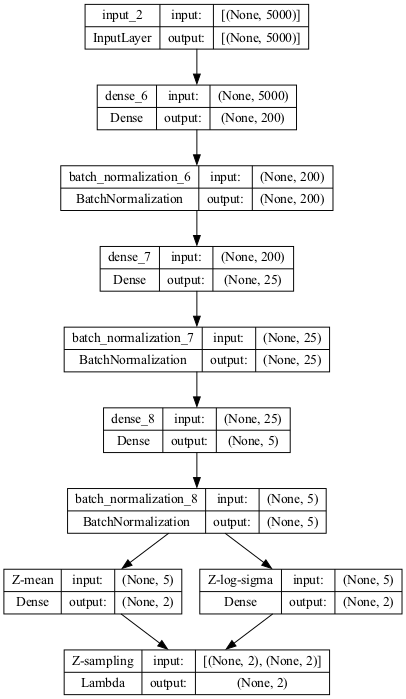

In [28]:
# Encoder
inputs = keras.Input(shape=(original_dim,))
outputs = inputs
h = layers.Dense(units = 200, activation = 'relu')(inputs)
h = layers.BatchNormalization()(h)
h = layers.Dense(units = 25, activation = 'relu')(h)
h = layers.BatchNormalization()(h)
h = layers.Dense(units = 5, activation = 'relu')(h)
h = layers.BatchNormalization()(h)

if (vanilla == True):
    z = layers.Dense(units = latent_dim, name='layer_bottleneck')(h)
    encoder = keras.Model(inputs, z, name='encoder')
else:
    # Bottleneck
    z_mean = layers.Dense(latent_dim, name = 'Z-mean')(h)
    z_log_sigma = layers.Dense(latent_dim, name = 'Z-log-sigma')(h)
    z = layers.Lambda(sampling, name = 'Z-sampling')([z_mean, z_log_sigma])
    encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(units = 5, activation = 'relu')(latent_inputs)
x = layers.BatchNormalization()(x)
x = layers.Dense(units = 25, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(units = 200, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(original_dim, activation='sigmoid', name='decoder-output')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
if (vanilla == True):
    outputs = decoder(encoder(inputs))
else:
    outputs = decoder(encoder(inputs)[2])
    
autoencoder = keras.Model(inputs, outputs, name='autoencoder')
plot_model(encoder, show_shapes = True, show_layer_names = True, dpi=70, to_file="enc_model.png")

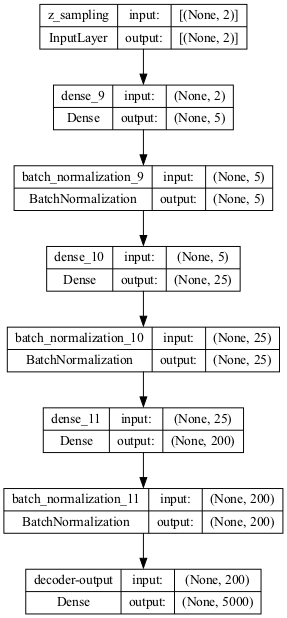

In [29]:
plot_model(decoder, show_shapes=True, show_layer_names = True, dpi=70, to_file="dec_model.png")

## Custom loss

In the case of VAE, we also need to provide our model with custom loss function that contains Kullback-Liebler divergence component.
After this, we are ready to train the model.

In [30]:
# Hyperparameters
hp_act_fn = 'relu'
hp_optimizer = 'adam'
hp_metrics = ['mse','mae','mape']

# KL divergence loss compares the encoded latent distribution Z 
# with standard Normal distribution and penalizes if it's too different
reconstruction_loss = original_dim * keras.losses.mse(inputs, outputs)  # use MSE
if (vanilla != True):
    KL_loss =  -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
    vae_loss = K.mean(reconstruction_loss + KL_loss)
else:
    vae_loss = reconstruction_loss
    
autoencoder.add_loss(vae_loss)

autoencoder.compile(
       optimizer = hp_optimizer,
       metrics = hp_metrics)

hp_epochs = 30

autoencoder.fit(train_tensor, train_tensor,
        epochs = hp_epochs,
        batch_size = 32,
        shuffle = True,
        validation_split = 0.2)

Epoch 1/30
30/30 [==============================] - 3s 27ms/step - loss: 918.3962 - mse: 0.1833 - mae: 0.3766 - mape: 336999744.0000 - val_loss: 887.4725 - val_mse: 0.1771 - val_mae: 0.3642 - val_mape: 332540160.0000
Epoch 2/30
30/30 [==============================] - 0s 15ms/step - loss: 816.5374 - mse: 0.1633 - mae: 0.3567 - mape: 315334272.0000 - val_loss: 729.6633 - val_mse: 0.1442 - val_mae: 0.3342 - val_mape: 294125120.0000
Epoch 3/30
30/30 [==============================] - 1s 20ms/step - loss: 578.5908 - mse: 0.1157 - mae: 0.3020 - mape: 250875632.0000 - val_loss: 477.9981 - val_mse: 0.0949 - val_mae: 0.2743 - val_mape: 214573824.0000
Epoch 4/30
30/30 [==============================] - 1s 21ms/step - loss: 391.6386 - mse: 0.0782 - mae: 0.2429 - mape: 172817552.0000 - val_loss: 368.2043 - val_mse: 0.0732 - val_mae: 0.2321 - val_mape: 152977616.0000
Epoch 5/30
30/30 [==============================] - 0s 16ms/step - loss: 335.9694 - mse: 0.0670 - mae: 0.2131 - mape: 128957992.0000

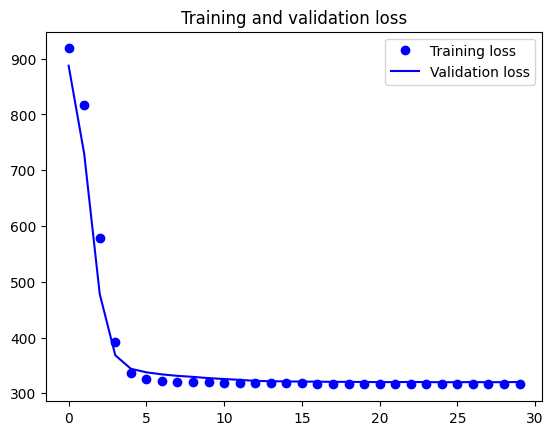

In [31]:
loss = autoencoder.history.history['loss']
val_loss = autoencoder.history.history['val_loss']
epochs = range(hp_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Embeddings

Now, let's look at our embeddings. Are they good enough?

### Task 5

Fill in the missing code. 

37/37 [==============================] - 0s 2ms/step
[array([[ 0.67263156,  0.21494912],
       [ 0.7885698 ,  0.23203857],
       [ 0.81793344,  0.17980748],
       ...,
       [ 1.1934892 , -0.08226179],
       [ 1.3820605 ,  0.25495526],
       [ 1.1836994 , -0.03724564]], dtype=float32), array([[-0.14548281, -0.71177465],
       [-0.09313202, -0.40690896],
       [-0.09139714, -0.48184258],
       ...,
       [ 0.00084373, -0.26185417],
       [ 0.3376896 , -0.11313191],
       [ 0.01291862, -0.20674238]], dtype=float32), array([[0.7696462 , 0.15527669],
       [0.9883451 , 0.31462944],
       [0.89147824, 0.12915394],
       ...,
       [1.0813572 , 0.03704428],
       [1.1468096 , 0.22736359],
       [1.2298574 , 0.05258949]], dtype=float32)]


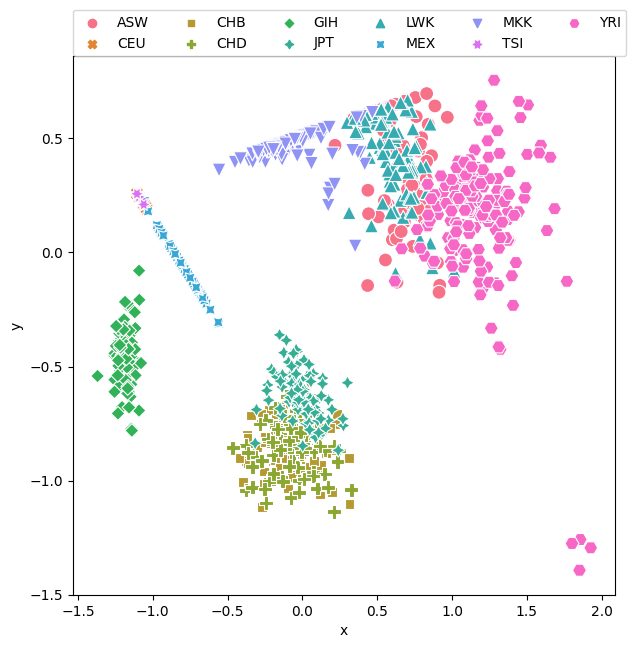

In [32]:
x_encoded = encoder.predict(geno_data, batch_size=32)
print(x_encoded)
if (vanilla != True):
    x = x_encoded[0][:, 0]
    y = x_encoded[0][:, 1]
else:
    x = x_encoded[:, 0]
    y = x_encoded[:, 1]
pop = pheno['population']
data_tmp = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (7, 7))
sns.scatterplot(x='x', y='y', data=data_tmp, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(0, 1), loc='lower left', borderaxespad=0, markerscale=1, ncol=6)
plt.show()

## Go generative!

Now, if you are using VAE, the real fun begins. We can go generative. Let's pick some coords on our latent space above, say [0.0, 0.3] and
randomly sample 10 individuals that are close to these. This will be our new artificial population of Neverlanders.

In [36]:
if (vanilla != True):
    N_ind = 10
    center = [0, 0.3] 
    cx = K.random_normal(shape = [N_ind], mean = center[0], stddev = 0.01)
    cy = K.random_normal(shape = [N_ind], mean = center[1], stddev = 0.01)
    z_sample = np.vstack((cx, cy)).T
    tf.print(z_sample)

array([[0.0228762 , 0.30934763],
       [0.00443876, 0.30453423],
       [0.01701441, 0.2926696 ],
       [0.01751175, 0.28924784],
       [0.02163949, 0.30785465],
       [0.00419375, 0.29482162],
       [0.01402003, 0.29872856],
       [0.00286014, 0.3077909 ],
       [0.022198  , 0.30398536],
       [0.00514609, 0.29643366]], dtype=float32)


We now use our decoder to translate these new datapoints to genotypes. 

In [37]:
if(vanilla != True):
    decoded = decoder.predict(z_sample)
    print(decoded)
    new_geno = np.zeros(shape = decoded.shape)
    new_geno[decoded <= 0.33] = 0
    new_geno[np.logical_and(decoded > 0.33, decoded < 0.66)] = 0.5
    new_geno[decoded >= 0.66] = 1
    print(new_geno)

1/1 [==============================] - 0s 17ms/step
[[0.44806117 0.23967655 0.20915653 ... 0.4677859  0.33820796 0.11913753]
 [0.45057818 0.24382979 0.20981236 ... 0.47269467 0.3386824  0.11606798]
 [0.45021904 0.24323879 0.20971774 ... 0.47202465 0.338592   0.11643879]
 ...
 [0.4504543  0.24362582 0.20977971 ... 0.47246352 0.33865124 0.11619578]
 [0.4486133  0.24058641 0.20929974 ... 0.46888158 0.33829778 0.1184182 ]
 [0.45123062 0.24492104 0.20994915 ... 0.47397077 0.33882773 0.11531791]]
[[0.5 0.  0.  ... 0.5 0.5 0. ]
 [0.5 0.  0.  ... 0.5 0.5 0. ]
 [0.5 0.  0.  ... 0.5 0.5 0. ]
 ...
 [0.5 0.  0.  ... 0.5 0.5 0. ]
 [0.5 0.  0.  ... 0.5 0.5 0. ]
 [0.5 0.  0.  ... 0.5 0.5 0. ]]


Let's see where will the articial genotypes end up if we feed them to our encoder along with the original data.

38/38 [==============================] - 0s 2ms/step


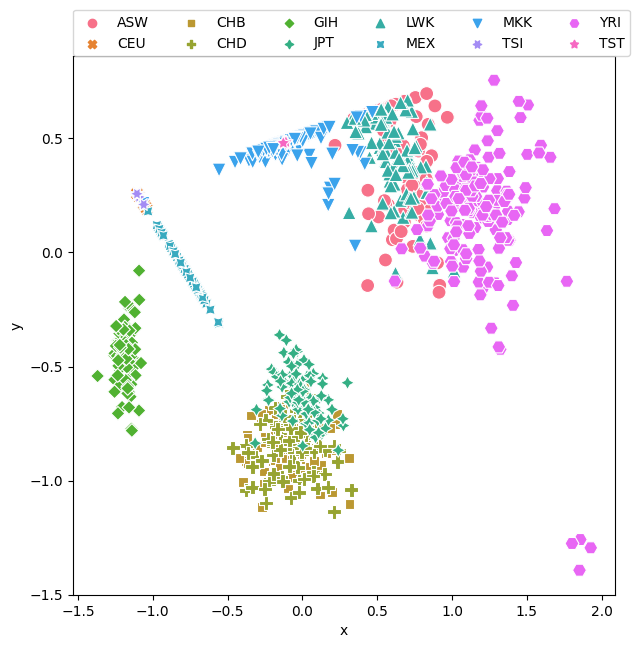

In [38]:
if(vanilla != True):
    x_encoded = encoder.predict(np.row_stack((geno_data, decoded)), batch_size=32)
    x = x_encoded[0][:, 0]
    y = x_encoded[0][:, 1]
    pop_list = [pheno['population'], pd.Series(np.repeat('TST', new_geno.shape[0]))]
    pop = pd.concat(pop_list) 
    data_tmp = {'x':x, 'y':y, 'pop':pop}
    plt.figure(figsize = (7, 7))
    sns.scatterplot(x='x', y='y', data=data_tmp, hue='pop', style='pop', s=100)
    plt.legend(bbox_to_anchor=(0, 1), loc='lower left', borderaxespad=0, markerscale=1, ncol=6)
    plt.show()

Not bad! Maybe they do not end up super exactly where our center point was (I am not sure why the coords sometimes end up a bit shifted) but they are more or less where we wanted them to be!

## PCA validation

Finally, let's see where classical PCA would place our Neverlanders.

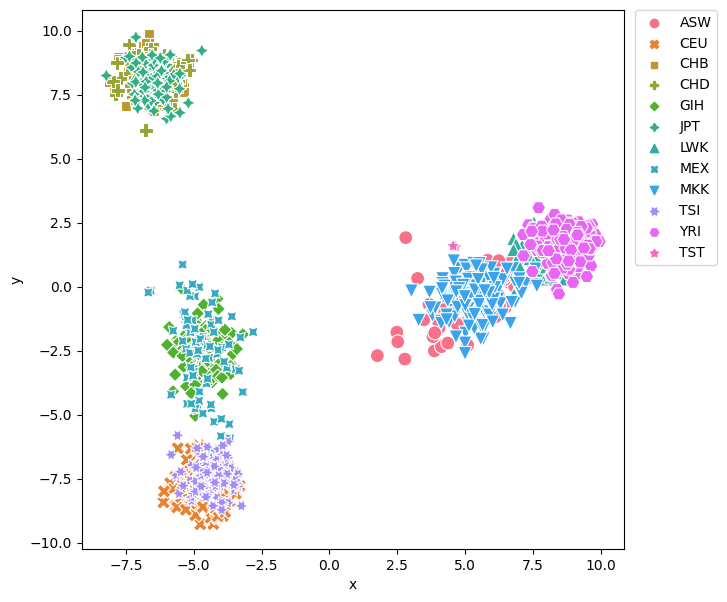

In [39]:
if (vanilla == True):
    input_genos = geno_data
else:
    input_genos = np.row_stack((geno_data, new_geno))
embedding = PCA(n_components = 2)
pca_embedding = embedding.fit_transform(input_genos * 2)
x = pca_embedding[:,0]
y = pca_embedding[:,1]
data = {'x':x, 'y':y, 'pop':pop}
plt.figure(figsize = (7,7))
sns.scatterplot(x='x', y='y', data=data, hue='pop', style='pop', s=100)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, markerscale=1)
plt.show()

### Task 6

Experiment with the models. You can:

* Modify architecture of our autoencoder, e.g. number of units, number of layers, add dropout, remove batch normalization.
* Modify epsilon variance in sampling layer. What happens? (optional)
* KL divergence is measuring distance to N(0,1). Change parameters of the distribution. What is the effect? What if you change to some other distribution? Does it make sense?
* Try to add some other artificial group of individuals. 

You do not have to do everything! I really want you to grasp the concept, see building blocks of a AE/VAE and experiment. Good luck!